# Distributions of Randomly-Initialized ANNs

This notebook builds a feed-forward network using PyTorch with configurable width, depth, and activation fuction; samples many random initializations (no training); and plots a histogram of the outputs for a fixed input. 
A normal curve with the same empirical mean and standard deviation is overlaid.

The initialization variance for the weights in the hidden layers is scaled by 1/width. The bias is zero. Under these conditions, the output distribution (the networks constructed here will always have one output with user-selected number of inputs) will approach a Gaussian distribution in the limit of large width. This is a consequence of the central limit theorem (CLT).


## ChatGPT prompts for original code

These are the prompts used to get started.

"Make me a pytorch script that takes as input a feed-forward network width and depth with one input and one output and a selected activation function. It should plot a histogram of the distribution of a large number of outputs with initialization of the weights and bias as mean zero Gaussians of specified width. There should be no training, only initialization. On the plot should also be plotted a normal distribution with the same mean and standard deviation as the output data."

"Now set this up as a jupyter notebook."

The notebook was edited to apply the scaling of the weight variance and several functions were created to consolidate the running of the model and subsequent plotting.

## Things to try:

* *Vary the width for a given depth and activation function. Try widths of 1, 10, 120, for example.*
* *Compare results with different activation functions. Do they all approach the CLT at the same rate?*
* *How does the behavior of the output distribution depend on the depth?*

## Code

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def build_model(width, depth, activation, in_features=1):
    """
    Build the PyTorch model with given specifications:
      - width --- integer width of each hidden layer
      - depth --- integer depth of layers
      - activation --- activation function, from a list
    """
    layers = []
    act = activation.lower()
    for _ in range(depth):
        layers.append(nn.Linear(in_features, width))
        if   act == 'relu':       layers.append(nn.ReLU())
        elif act == 'tanh':       layers.append(nn.Tanh())
        elif act == 'sigmoid':    layers.append(nn.Sigmoid())
        elif act == 'elu':        layers.append(nn.ELU())
        elif act in ('leaky_relu','leaky-relu'):
                                   layers.append(nn.LeakyReLU())
        elif act in ('none','linear'):
                                   pass
        else:
            raise ValueError(f"Unknown activation '{activation}'")
        in_features = width

    layers.append(nn.Linear(in_features, 1))
    return nn.Sequential(*layers)

def initialize_model(model, w_std, b_std):
    """
    Initialize the ANN with given weight and bias std's.
    The means for each distribution are zero.
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=w_std)
            nn.init.normal_(m.bias,   mean=0.0, std=b_std)


In [3]:
def run_model(width, depth, activation, weight_std, bias_std, in_features, input_val, n_samples=20000):
    """
    Build and run the model given all the inputs for n_samples samples.
    Using torch.no_grad() for initialization only.
      input_val --- float input value to the ANN
    """
    outputs = np.empty(n_samples, dtype=np.float32)
    x_tensor = torch.tensor([input_val], dtype=torch.float32)

    for i in range(n_samples):
        net = build_model(width, depth, activation, in_features)
        initialize_model(net, weight_std, bias_std)
        with torch.no_grad():
            outputs[i] = net(x_tensor).item()

    # get the mean and std of the distribution of outputs
    mu, sigma = outputs.mean(), outputs.std()  
    print(f"Sampled {n_samples} outputs →  mean = {mu:.4f}, std = {sigma:.4f}")

    return outputs, mu, sigma


In [4]:
def make_plot(width, depth, activation, outputs, mean, std, 
              bins=50, range=(-.5,.5), xlims=None, ylims=None):
    """
    Plot a histogram with an overlaid normal distribution with the same mean and std.
       bins --- integer number of histogram bins
       range --- tuple of floats giving the limits of the bins
       xlim --- tuple of minimum and maximum x (default autoscale)
       ylim --- tuple of minimum and maximum y (default autoscale)
    """
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(outputs, bins=bins, range=range, density=True, alpha=0.6, label="Network outputs")
    
    xs = np.linspace(mean - 4*std, mean + 4*std, 200)
    ys = 1/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((xs-mean)/std)**2)
    ax.plot(xs, ys, 'r--', lw=2,
             label=f"Normal(μ={mean:.3f}, σ={std:.3f})")
    
    ax.set_title(f"Depth={depth}, Width={width}, Activation={activation}")
    ax.set_xlabel("Output value")
    ax.set_ylabel("Density")
    if (xlims):
        ax.set_xlim(xlims)
    if (ylims):
        ax.set_ylim(ylims)
    ax.legend()
    fig.tight_layout()
    return fig, ax


## Output Distribution of Randomly-Initialized feed-forward ANN (1 Input → 1 Output)


In [5]:
# ─── USER CONFIG ────────────────────────────────────────
width       = 10      # neurons per hidden layer
depth       = 3        # number of hidden layers
activation  = 'relu'   # relu, tanh, sigmoid, elu, leaky_relu, none
weight_std  = 2.0 / np.sqrt(width)     # stddev for weight init, variance normalized by 1/width
bias_std    = 0.0   # stddev for bias init
n_samples   = 20000    # number of random networks to sample
in_features = 1       # number of input features
input_val   = 1.      # scalar input to feed-forward
# ───────────────────────────────────────────────────────


In [6]:
my_output, my_mu, my_sigma = run_model(width, depth, activation, weight_std, bias_std, in_features, input_val, n_samples)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Sampled 20000 outputs →  mean = -0.0069, std = 1.8009


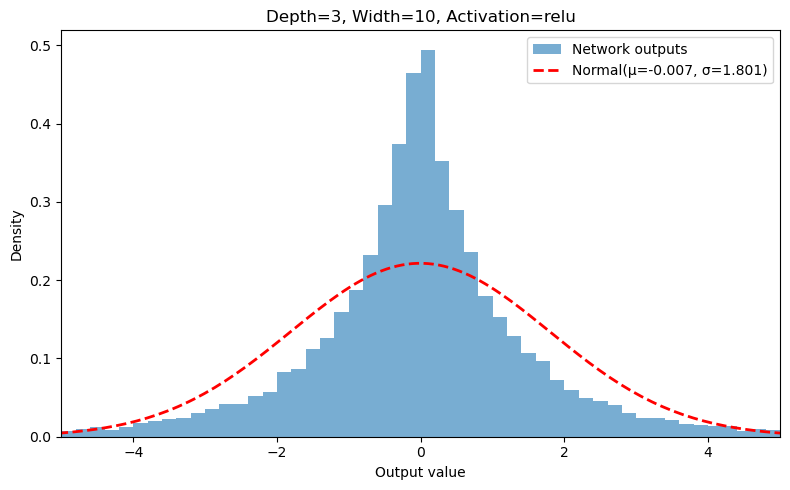

In [7]:
my_fig, my_ax = make_plot(width, depth, activation, my_output, my_mu, my_sigma, 
                          bins=50, range=(-5,5), xlims=(-5,5))

## Output Distribution of Randomly-Initialized feed-forward ANN (2 Inputs → 1 Output)


In [17]:
# ─── USER CONFIG ────────────────────────────────────────
width       = 10            # neurons per hidden layer
depth       = 3            # number of hidden layers
activation  = 'tanh'       # relu, tanh, sigmoid, elu, leaky_relu, none
weight_std  = 2.0 / np.sqrt(width)         # stddev for weight init with variance * 1/width
bias_std    = 0.0          # stddev for bias init
n_samples   = 40000        # number of random networks to sample
in_features = 2            # number of input features
input_val  = [0.13, 0.16]  # 2-dimensional input vector
# ───────────────────────────────────────────────────────


In [18]:
my_output, my_mu, my_sigma = run_model(width, depth, activation, weight_std, bias_std, in_features, input_val, n_samples)

Sampled 40000 outputs →  mean = 0.0014, std = 0.7845


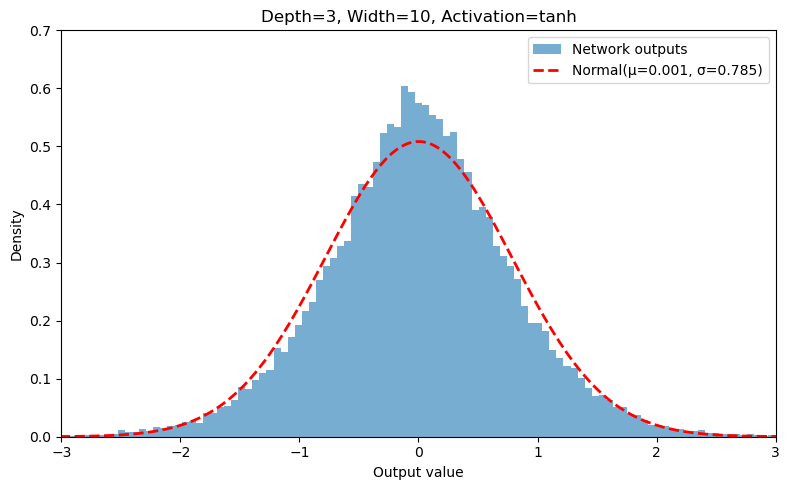

In [19]:
my_fig, my_ax = make_plot(width, depth, activation, my_output, my_mu, my_sigma, 
                          bins=101, range=(-3,3), xlims=(-3,3), ylims=(0,0.7))